# Electricity Demand Forecasting Project | Part 1 - Linear Models

**Import libraries and packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime as dt

from matplotlib.lines import Line2D
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

## 1. Import, Clean and Explore Data

The following data has been used for this project:
1. Electricity demand data for the Netherlands, at a 15-minute time interval, available from the ENTSO-E Transparency Platform: https://transparency.entsoe.eu/.
2. Weather data for the Netherlands, at a 1-hour time interval, available from the Netherlands Meteorological Institute: https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens.


**Electricity Demand Data**

The ENTSO-E Transparency Platform manages the central collection and publication of electricity generation, transportation and consumption data and information for the pan-European market. As we are focusing on electricity demand, we make use of the data included in the **Total Load - Day Ahead/Actual** view.

Data is downloaded per year for the period 2015 - 2025 (up to 30/04/2025). Actual Total Load, which represents electricity demand, will be used.


**Weather Data**

We will assess the relationship between the weather conditions and electricity demand, and whether the inclusion of weather data can improve our model forecasts.

KNMI data includes 50 weather stations. In line with their "Central Netherlands Temperature (CNT)" approach we have selected the following stations: De Bilt, Winterswijk/Hupsel, Oudenbosch/Gilze Rijen, Gemert/Volkel, Deelen and Eindhoven.

Weather data is only available from 1 June 2015. Therefore, we will start our analysis (of both electricity data and weather data) from 1 January 2016.

In [2]:
# Import Electricity Demand Data
data_dict = {}

for data_year in range(2016, 2025):
    data_dict[data_year] = pd.read_csv(f'data/total_load_{data_year}.csv')

data_full = pd.concat(data_dict.values())

data_2025 = pd.read_csv('data/total_load_2025.csv')

In [3]:
pd.concat([data_full.head(2), data_full.tail(2)])

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|NL,Actual Total Load [MW] - BZN|NL
0,01.01.2016 00:00 - 01.01.2016 00:15,11169.0,10924.0
1,01.01.2016 00:15 - 01.01.2016 00:30,10933.0,10905.0
35138,31.12.2024 23:30 - 31.12.2024 23:45,12948.0,12259.0
35139,31.12.2024 23:45 - 01.01.2025 00:00,12778.0,12195.0


The data is displayed in 15-min time intervals. For time series indexing purposes we will use the opening time of each instance, i.e. 01.01.2015 00:00 - 01.01.2015 00:15, will simply be represented as 01.01.2015 00:00. Using the opening time ensures that all instances remaing within the relevant larger time window.

In [4]:
# Check data for duplicates
data_full['Time (CET/CEST)'].duplicated().sum()

36

In [5]:
data_full[data_full['Time (CET/CEST)'].duplicated(keep=False)][:16]

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|NL,Actual Total Load [MW] - BZN|NL
29096,30.10.2016 02:00 - 30.10.2016 02:15,10759.0,9684.0
29097,30.10.2016 02:15 - 30.10.2016 02:30,10714.0,9687.0
29098,30.10.2016 02:30 - 30.10.2016 02:45,10680.0,9603.0
29099,30.10.2016 02:45 - 30.10.2016 03:00,10646.0,9519.0
29100,30.10.2016 02:00 - 30.10.2016 02:15,10759.0,9450.0
29101,30.10.2016 02:15 - 30.10.2016 02:30,10714.0,9437.0
29102,30.10.2016 02:30 - 30.10.2016 02:45,10680.0,9389.0
29103,30.10.2016 02:45 - 30.10.2016 03:00,10646.0,9374.0
28904,29.10.2017 02:00 - 29.10.2017 02:15,9994.0,9796.0
28905,29.10.2017 02:15 - 29.10.2017 02:30,9955.0,9817.0


In [6]:
# Check data for null values 
data_full['Actual Total Load [MW] - BZN|NL'].isna().sum()

36

In [7]:
data_full[data_full['Actual Total Load [MW] - BZN|NL'].isna()][:8]

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|NL,Actual Total Load [MW] - BZN|NL
8264,27.03.2016 02:00 - 27.03.2016 02:15,NaN,NaN
8265,27.03.2016 02:15 - 27.03.2016 02:30,NaN,NaN
8266,27.03.2016 02:30 - 27.03.2016 02:45,NaN,NaN
8267,27.03.2016 02:45 - 27.03.2016 03:00,NaN,NaN
8072,26.03.2017 02:00 - 26.03.2017 02:15,NaN,NaN
8073,26.03.2017 02:15 - 26.03.2017 02:30,NaN,NaN
8074,26.03.2017 02:30 - 26.03.2017 02:45,NaN,NaN
8075,26.03.2017 02:45 - 26.03.2017 03:00,NaN,NaN


There appears to be a recurring annual issue in the data:
- 4 consecutive intervals on a date in March (02:00-02:15) are missing.
- 4 consecutive intervals on a date in October (02:00-02:15) are duplicated.

As this is limited number of values, we can fill the NaN values with a forward fill, and drop the duplicated values.

In [8]:
# Create a helper function to reformat our data to our needs
def format_data(df):
    """
    Formats the dataframe, removes duplicates and fills NaN values.
    """
    df.drop('Day-ahead Total Load Forecast [MW] - BZN|NL', axis=1, inplace=True)
    df.columns = ['Time', 'Load']
    df[['Date', 'End']] = df['Time'].str.split(' - ', expand=True)
    df.set_index(pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M'), inplace=True)
    df.drop(['Time', 'Date', 'End'], axis=1, inplace=True)
    df.sort_index(inplace=True)

    df = df[~df.index.duplicated(keep='first')].copy()
    df.ffill(inplace=True)

    return df

In [9]:
data_full = format_data(data_full)

data_2025 = format_data(data_2025)
data_2025.drop(data_2025.loc['2025-05-01':].index, inplace=True)
data_2025['Load'] = data_2025['Load'].astype(float)

In [10]:
# Check length of dataset - result should be 0
len(data_full) - (dt.date(2025, 1, 1) - dt.date(2016, 1, 1)).days * 96

0

In [11]:
pd.concat([data_full.head(1), data_full.tail(1)])

,Load
Date,
2016-01-01 00:00:00,10924.0
2024-12-31 23:45:00,12195.0


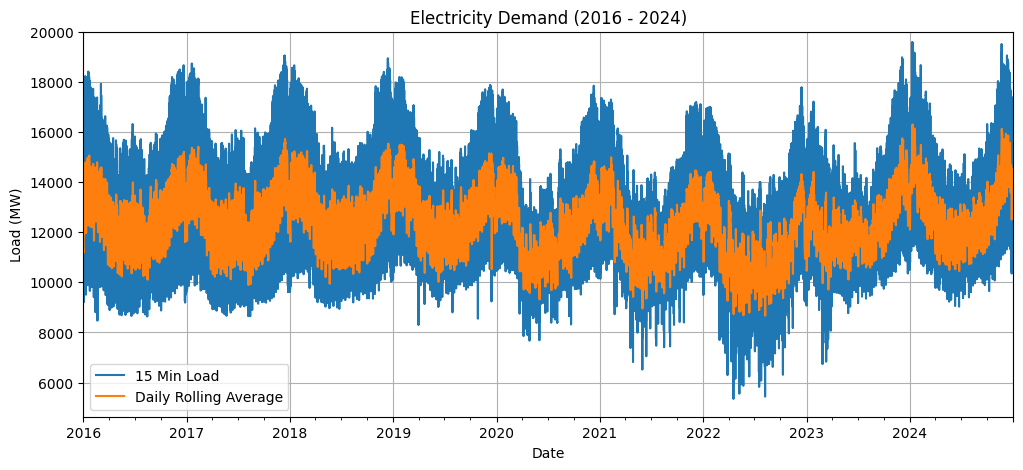

In [12]:
# Plot 2016-2024 data with rolling daily average
fig, ax = plt.subplots(figsize=(12, 5))

data_full.plot(ax=ax)

rolling_daily_average = data_full.rolling(window=96).mean() # 96 15-min intervals per day
rolling_daily_average.plot(ax=ax)

plt.title('Electricity Demand (2016 - 2024)')
plt.legend(['15 Min Load', 'Daily Rolling Average'])
plt.ylim(None, 20000)
plt.ylabel('Load (MW)')
plt.grid();

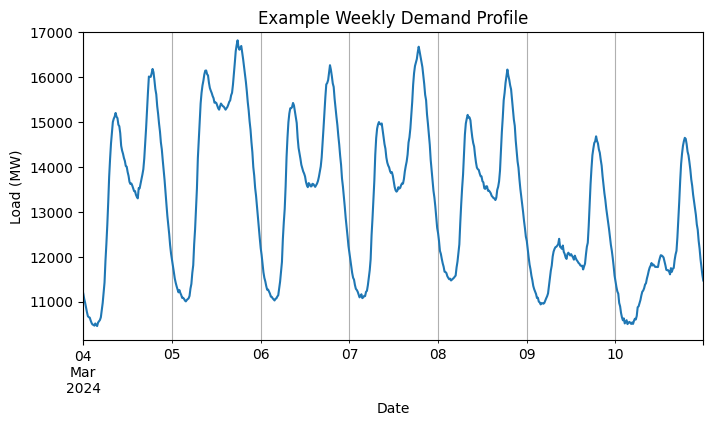

In [13]:
# An example weekly load profile - first week of March 2024 (Mon to Sun)
data_full.loc['2024-03-04':'2024-03-10'].plot(figsize=(8, 4))
plt.title('Example Weekly Demand Profile')
plt.ylabel('Load (MW)')
plt.grid(axis='x', which='both')
plt.legend().remove()
plt.ylim(None, 17000);

What we immediately notice are the following trends:
1. Consistent daily pattern, with a different profile for weekdays and weekends.
2. Annual/seasonal trend with electricity demand increasing towards the winter months and decreasing torwards the summer months.

#### Mean Daily Analysis

In [14]:
# Recreate DataFrame stacking daily data for purpose of daily demand profile analysis
data_time = data_full.copy()
data_time['Day'] = data_time.index.date
data_time['Time'] = data_time.index.time
data_time_pivot = data_time.pivot(index='Day', columns='Time', values='Load')
data_time_pivot['Year'] = pd.to_datetime(data_time_pivot.index).year

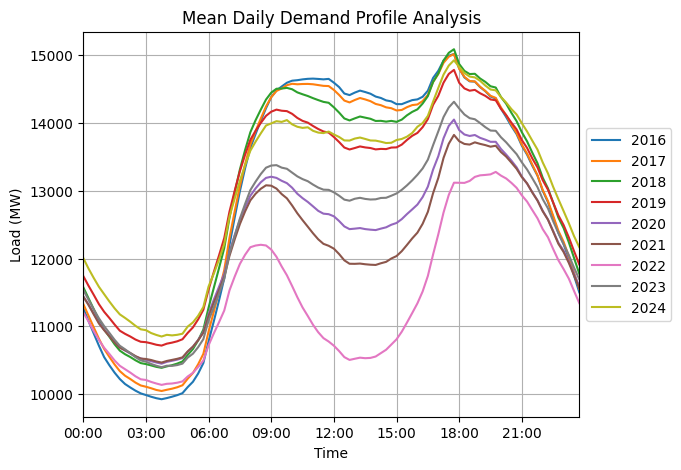

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

data_time_pivot.groupby(by='Year').mean().T.plot(ax=ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim('00:00:00','23:45:00')
ax.set_xticks(list(data_time_pivot.columns[:-1:12]))
ax.grid()
plt.title('Mean Daily Demand Profile Analysis')
plt.ylabel('Load (MW)');

#### Day of week / holiday analysis

In [16]:
data_time['Weekday'] = data_time.index.weekday
public_holidays_full = list(holidays.country_holidays(country='Netherlands', years=range(2016, 2026)).keys())
data_time['Holiday'] = pd.to_datetime(data_time.index.date).isin(pd.to_datetime(public_holidays_full))

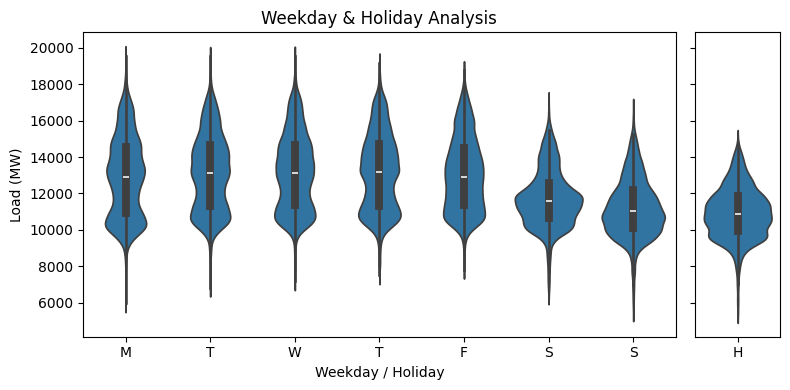

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [7,1]})
sns.violinplot(x='Weekday', y='Load', data=data_time, ax=ax[0])
ax[0].set_xticks(ticks=np.arange(7), labels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
sns.violinplot(data=data_time[data_time['Holiday']], y='Load', ax=ax[1])
ax[1].set_xticks(ticks=[0], labels=['H'])

ax[0].set_title('Weekday & Holiday Analysis')
ax[0].set_xlabel('Weekday / Holiday')
ax[0].set_ylabel('Load (MW)')
plt.tight_layout();

Two clearly separate profiles arise: weekday and weekend/holiday. However, there are noticeable differences between individual days as well, namely the range of values(see Wednesday vs Friday), and concentration around the mean (see Saturday vs Sunday).

#### Autocorrelation Analysis

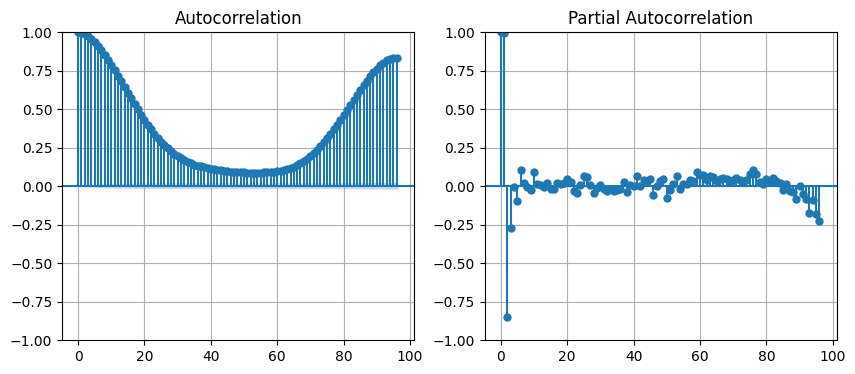

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(data_full['Load'], ax=ax[0], lags=96)
ax[0].grid()
plot_pacf(data_full['Load'], ax=ax[1], lags=96)
ax[1].grid();

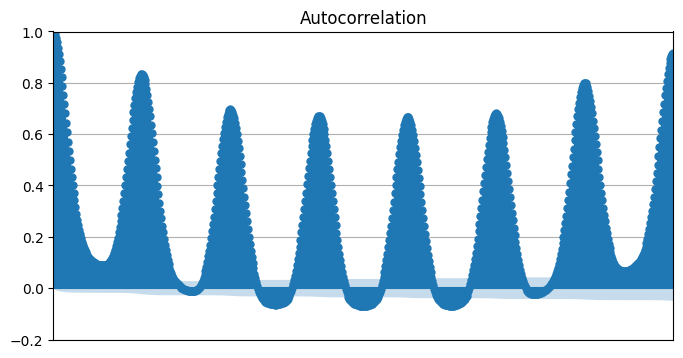

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_acf(data_full['Load'], ax=ax, lags=96*7)
ax.set_xlim(0, (96*7))
ax.set_ylim(-0.2, 1)
ax.grid()
ax.set_xticks([]);

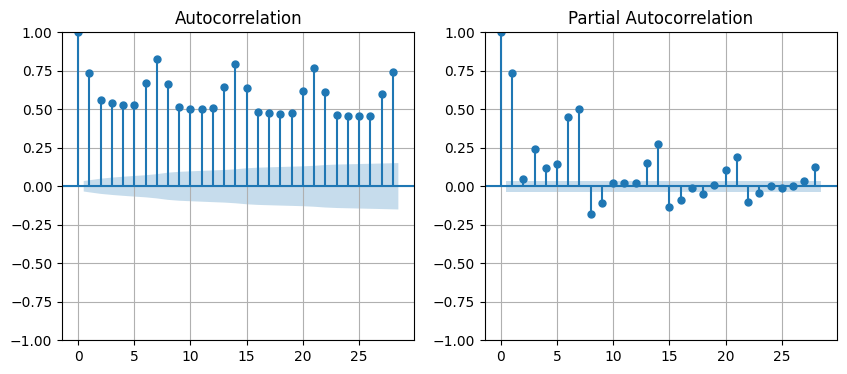

In [20]:
# Repeat with all midday data points
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(
    data_full[data_full.index.time == data_full.index.time[48]],
    ax=ax[0], lags=28)
ax[0].grid()

plot_pacf(
    data_full[data_full.index.time == data_full.index.time[48]],
    ax=ax[1], lags=28)
ax[1].grid();

From the autocorrelation analysis, we can see that the next 15-min load value will follow the previous value(s) very closely. This drops off and picks up again as the lag period approaches the corresponding time interval from the previous day. As our model will be predicting 24-hours ahead, the first available lag value will be that corresponding prior day value. We also see that the value with the highest correlation (from one day onwards) is the corresponding time value from one week prior, due to differences in daily profiles over the week.

Therefore, the following lag values appear most relevant:
1. The corresponding time value 24 hours prior (starting point).
2. A number of trailing 15-min values thereafter (to be assessed).
3. A number of trailing  daily prior values (matching time frame), up to at least 1 week prior as the value from the same day and time has the highest correlation.

#### Weather Data Analysis

In [21]:
# Import weather data
weather_dict = {}

for data_year in range(2016, 2025):
    weather_dict[data_year] = pd.read_csv(f'data/weather_{data_year}.csv', low_memory=False)

weather_full = pd.concat(weather_dict.values())

weather_full_columns = [column.strip() for column in weather_full.columns]
weather_full.columns = weather_full_columns

In [22]:
weather_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473472 entries, 0 to 52703
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   # STN     473472 non-null  int64 
 1   YYYYMMDD  473472 non-null  int64 
 2   HH        473472 non-null  int64 
 3   DD        473472 non-null  int64 
 4   FH        473472 non-null  int64 
 5   FF        473472 non-null  int64 
 6   FX        473472 non-null  int64 
 7   T         473472 non-null  int64 
 8   T10N      473472 non-null  object
 9   TD        473472 non-null  int64 
 10  SQ        473472 non-null  int64 
 11  Q         473472 non-null  int64 
 12  DR        473472 non-null  int64 
 13  RH        473472 non-null  int64 
 14  P         473472 non-null  object
 15  VV        473472 non-null  object
 16  N         473472 non-null  object
 17  U         473472 non-null  int64 
 18  WW        473472 non-null  object
 19  IX        473472 non-null  int64 
 20  M         473472 non-null  objec

A summary of the included variables:

- DD: Mean wind direction (in degrees) during the 10-minute period preceding the time of observation (360=north; 90=east; 180=south; 270=west; 0=calm 990=variable)
- FH: Hourly mean wind speed (in 0.1 m/s)
- FF: Mean wind speed (in 0.1 m/s) during the 10-minute period preceding the time of observation
- FX: Maximum wind gust (in 0.1 m/s) during the hourly division
- T: Temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
- T10N: Minimum temperature (in 0.1 degrees Celsius) at 0.1 m in the preceding 6-hour period
- TD: Dew point temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
- SQ: Sunshine duration (in 0.1 hour) during the hourly division; calculated from global radiation (-1 for <0.05 hour)
- Q: Global radiation (in J/cm2) during the hourly division
- DR: Precipitation duration (in 0.1 hour) during the hourly division
- RH: Hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
- P: Air pressure (in 0.1 hPa) reduced to mean sea level; at the time of observation
- VV: Horizontal visibility at the time of observation (0=less than 100m; 1=100-200m; 2=200-300m;...; 49=4900-5000m; 50=5-6km; 56=6-7km; 57=7-8km; ...; 79=29-30km; 80=30-35km; 81=35-40km;...; 89=more than 70km)
- N: Cloud cover (in octants); at the time of observation (9=sky invisible)
- U: Relative atmospheric humidity (in percents) at 1.50 m at the time of observation
- WW: Present weather code (00-99); description for the hourly division.
- IX: Indicator present weather code (1=manned and recorded (using code from visual observations); 2;3=manned and omitted (no significant weather phenomenon to report; not available); 4=automatically recorded (using code from visual observations); 5;6=automatically omitted (no significant weather phenomenon to report; not available); 7=automatically set (using code from automated observations)
- M: Fog 0=no occurrence; 1=occurred during the preceding hour and/or at the time of observation
- R: Rainfall 0=no occurrence; 1=occurred during the preceding hour and/or at the time of observation
- S: Snow 0=no occurrence; 1=occurred during the preceding hour and/or at the time of observation
- O: Thunder  0=no occurrence; 1=occurred during the preceding hour and/or at the time of observation
- Y: Ice formation 0=no occurrence; 1=occurred during the preceding hour and/or at the time of observation

Some/many of these fields are not expected to be relevant for our anaylsis. Furthermore, not all are comprehensively recorded across the selected weather stations. We will therefore first drop partially recorded fields, and thereafter perform a correlation analysis to see if we can identify any fields of interest.

In [23]:
# Check for duplicates
weather_full[weather_full.columns[:3]].duplicated().sum()

0

In [24]:
# Format out blank spaces in the data, and filter on partially recorded fields
weather_full = weather_full.map(lambda x: x.strip() if isinstance(x, str) else x)
weather_full.replace('', np.NaN, inplace=True)

weather_full[weather_full.select_dtypes(include='object').columns] = (
    weather_full[weather_full.select_dtypes(include='object').columns].astype(float))

weather_full.isna().sum()[weather_full.isna().sum()>0]

T10N    394667
P        78912
VV       79044
N        80182
WW      313970
M        79111
R        79111
S        79111
O        79111
Y        79111
dtype: int64

We can drop all of these fields without losing meaningful information for our anaylsis:
- T10N/WW: Majority do not record this field.
- P/VV/N: do not appear particularly relevant or will be addressed through comparable fields.
- M-Y: these are yes/no variables for certain weather conditions. Our analysis will include weather measurements (e.g. precipitation amount instead of rainfall occurence (yes/no)).

We will also drop field IX, which is numerically categorical and not a measurement of a weather value.

In [25]:
# Drop these columns
weather_full.drop(weather_full.isna().sum()[weather_full.isna().sum()>0].index, axis=1, inplace=True)
weather_full.drop('IX', axis=1, inplace=True)

As our weather data includes hourly measurements, we will need to "broadcast" the data to max the 15-min intervals of our electricity data. We will therefore apply the hourly value against each 15-min interval within that hour.

In [26]:
# Drop stations, group by date and hour and expand to 4 rows per hour
weather_full.drop('# STN', axis=1, inplace=True)
weather_full_grouped = weather_full.groupby(by=['YYYYMMDD','HH']).mean()

weather_full_grouped = pd.concat([weather_full_grouped] * 4)
weather_full_grouped.sort_values(by=['YYYYMMDD', 'HH'], axis=0, inplace=True)

weather_full_grouped[:10]

DD         FH         FF         FX     T         TD  \
YYYYMMDD HH                                                                 
20160101 1   196.666667  41.666667  41.666667  71.666667  65.5  38.500000   
         1   196.666667  41.666667  41.666667  71.666667  65.5  38.500000   
         1   196.666667  41.666667  41.666667  71.666667  65.5  38.500000   
         1   196.666667  41.666667  41.666667  71.666667  65.5  38.500000   
         2   201.666667  41.666667  36.666667  68.333333  64.5  41.666667   
         2   201.666667  41.666667  36.666667  68.333333  64.5  41.666667   
         2   201.666667  41.666667  36.666667  68.333333  64.5  41.666667   
         2   201.666667  41.666667  36.666667  68.333333  64.5  41.666667   
         3   203.333333  35.000000  30.000000  61.666667  58.0  41.333333   
         3   203.333333  35.000000  30.000000  61.666667  58.0  41.333333   

              SQ    Q   DR        RH          U  
YYYYMMDD HH                                      
20160101 1   0.0  0.0  0.0 -0.166667  82.833333  
         1   0.0  0.0  0.0 -0.166667  82.833333  
         1   0.0  0.0  0.0 -0.166667  82.833333  
         1   0.0  0.0  0.0 -0.166667  82.833333  
         2   0.0  0.0  0.0 -0.500000  85.166667  
         2   0.0  0.0  0.0 -0.500000  85.166667  
         2   0.0  0.0  0.0 -0.500000  85.166667  
         2   0.0  0.0  0.0 -0.500000  85.166667  
         3   0.0  0.0  0.0 -0.333333  88.833333  
         3   0.0  0.0  0.0 -0.333333  88.833333

In [27]:
# Recreate original date index and insert load data
temp_index = [pd.to_datetime('2016-01-01 00:00:00')]
for i in range(len(weather_full_grouped)-1):
    temp_index.append(temp_index[i] + pd.Timedelta('00:15:00'))

weather_full_grouped.index = pd.to_datetime(temp_index)

weather_full_grouped.insert(loc=0, column='Load', value=data_full.loc['2016-01-01':'2024-12-31', 'Load'])

In [28]:
weather_full_grouped[:2]

,Load,DD,FH,FF,FX,T,TD,SQ,Q,DR,RH,U
2016-01-01 00:00:00,10924.0,196.666667,41.666667,41.666667,71.666667,65.5,38.5,0.0,0.0,0.0,-0.166667,82.833333
2016-01-01 00:15:00,10905.0,196.666667,41.666667,41.666667,71.666667,65.5,38.5,0.0,0.0,0.0,-0.166667,82.833333


Now we can perform our correlation anaylsis.
- p <0.3: weak correlation
- 0.3 <= p < 0.5: moderate correlation
- p >= 0.5: strong correlation

In [29]:
weather_full_grouped.corr()['Load'].sort_values(ascending=False)

Load    1.000000
FH      0.157983
FX      0.154785
FF      0.151069
DR      0.120911
U       0.089494
RH      0.070296
DD      0.041061
SQ     -0.093890
Q      -0.095742
TD     -0.163445
T      -0.192257
Name: Load, dtype: float64

At first glance, all fields appear weakly correlated with the temperature indicators having the highest (absolute) value, followed closely by wind and precipitation indicators. However, the analysis is based on hourly data where a moving average may exhibit stronger correlation. We will also standardise the data for the purpose of plotting load values vs weather values on the same scale.

In [30]:
# Standardise the weather data
std_weather = StandardScaler()

weather_full_transformed = pd.DataFrame(std_weather.fit_transform(weather_full_grouped),
                                         columns=weather_full_grouped.columns,
                                         index=weather_full_grouped.index)

weather_full_rolling = weather_full_transformed.rolling(window=96).mean() # daily rolling average

In [31]:
# Set the Load value in the rolling DataFrame back to the 15-min actual values
# We will keep the rolling load value for plotting purposes
weather_full_rolling.rename(columns={'Load':'Load_rolling'}, inplace=True)
weather_full_rolling.insert(loc=0, column='Load', value=weather_full_transformed['Load'].values)

In [32]:
weather_full_rolling.corr()['Load'].sort_values(ascending=False)

Load            1.000000
Load_rolling    0.603587
U               0.285719
DR              0.152663
FH              0.105927
FF              0.105593
FX              0.084490
RH              0.080000
DD             -0.009261
TD             -0.209777
T              -0.298209
SQ             -0.299116
Q              -0.379267
Name: Load, dtype: float64

After applying the rolling average, we see radiation/temperature-associated fields (Q - global radiation, T - temperature, SQ - sunshine duration, U - relative humidity) emerging with the strongest correlation, albeit only global radiation exceeding the threshold for moderate correlation.

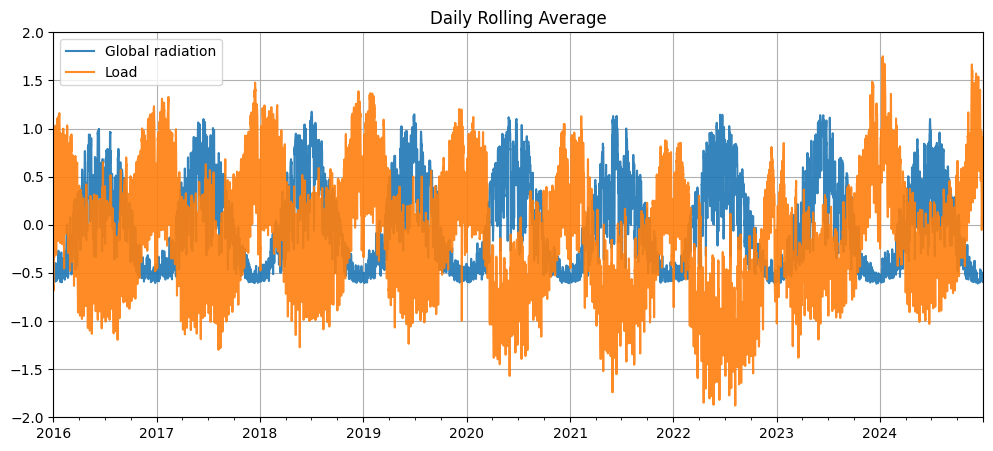

In [33]:
weather_full_rolling[['Q', 'Load_rolling']].plot(figsize=(12, 5), alpha=0.9)
plt.title('Daily Rolling Average')
plt.legend(['Global radiation', 'Load'])
plt.ylim(-2, 2)
plt.grid();

Let's extend this by evaluating the correlation effect of a longer rolling average period (e.g. 1 week).

In [34]:
weather_full_rolling_weekly = weather_full_transformed.rolling(window=(96*7)).mean() # weekly rolling average
weather_full_rolling_weekly.rename(columns={'Load':'Load_rolling'}, inplace=True)
weather_full_rolling_weekly.insert(loc=0, column='Load', value=weather_full_transformed['Load'].values)

In [35]:
weather_full_rolling_weekly.corr()['Load'].sort_values(ascending=False)

Load            1.000000
Load_rolling    0.507642
U               0.320654
DR              0.196339
FH              0.143307
FF              0.142735
FX              0.110239
RH              0.071157
DD             -0.037728
TD             -0.237259
T              -0.314133
SQ             -0.330023
Q              -0.380637
Name: Load, dtype: float64

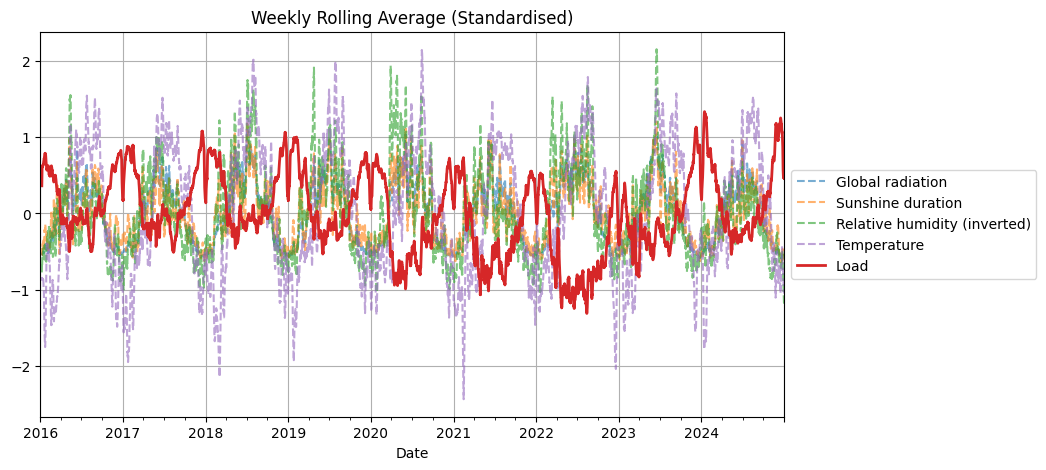

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))

weather_full_rolling_weekly['U_inverse'] = weather_full_rolling_weekly['U']*-1

weather_full_rolling_weekly[['Q', 'SQ', 'U_inverse', 'T']].plot(ax=ax, linestyle='--', alpha=0.6,
                                                               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd'])
weather_full_rolling_weekly['Load_rolling'].plot(ax=ax, linewidth=2, color='#d62728')
ax.set_title('Weekly Rolling Average (Standardised)')
ax.set_xlabel('Date')
ax.grid()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(['Global radiation', 'Sunshine duration', 'Relative humidity (inverted)', 'Temperature', 'Load'],
          loc='center left', bbox_to_anchor=(1, 0.5));

A weekly rolling average now yields 4 fields with moderate correlation (with global radiation remaining the strongest correlation). These fields are all related, as can be seen from the above plot. Global radiation increases with sunshine duration, and relative humidity decreases as temperatures increase.

For our validation and test data, we will use historical forecast data, as when we predict electricity demand 24-hours ahead, we would use the weather forecat for that day.

Weather forecast data is retrieved via the Open Meteo API, which pulls from KNMI data: https://open-meteo.com/en/docs/historical-forecast-api.

The following co-ordinates are applicable for the six weather stations used above:
- De Bilt (260): 52.100, 5.180
- Deelen (275): 52.056, 5.873
- Hupsel (283): 52.069, 6.657
- Gilze-Rijen (350): 51.566, 4.936
- Eindhoven (370): 51.451, 5.377
- Volkel (375): 51.659, 5.707 

In [37]:
weather_forecast = pd.read_csv('data/weather_forecast_2425.csv')
weather_forecast.head()

,location_id,time,temperature_2m (°C),relative_humidity_2m (%),sunshine_duration (s),global_tilted_irradiance (W/m²)
0,0,2024-01-01T00:00,8.5,81,0.0,0.0
1,0,2024-01-01T01:00,8.5,79,0.0,0.0
2,0,2024-01-01T02:00,7.7,78,0.0,0.0
3,0,2024-01-01T03:00,7.2,80,0.0,0.0
4,0,2024-01-01T04:00,6.9,85,0.0,0.0


In [38]:
weather_forecast.drop('location_id', axis=1, inplace=True)
weather_forecast.columns=['Time', 'T', 'U', 'SQ', 'Q']
weather_forecast['Time'] = pd.to_datetime(weather_forecast['Time'])

weather_forecast = weather_forecast.loc[:, ['Time', 'Q', 'SQ', 'U', 'T']] # reorder

Some of the fields in the forecast data are expressed in different units compared to those in the original KNMI data. These will therefore need to be converted to consistent measurements.

Unit conversions:
- T: training data is expressed as 10x degrees celcius. Therefore x10.
- U: same scale (%).
- Q: training data is expressed as J/cm2. The conversion from W/m2 is x 86400 / 10000.
- SQ: training data is expressed in 0.1 hours. The conversion from seconds is / 360.

In [39]:
weather_forecast['T'] = weather_forecast['T'] * 10
weather_forecast['Q'] = weather_forecast['Q'] * 60 * 60 / 10000
weather_forecast['SQ'] = weather_forecast['SQ'] / 360

In [40]:
weather_forecast_grouped = weather_forecast.groupby(by='Time').mean()
weather_forecast_grouped = pd.concat([weather_forecast_grouped] * 4)
weather_forecast_grouped.sort_values(by='Time', axis=0, inplace=True)

temp_index = [pd.to_datetime('2024-01-01 00:00:00')]
for i in range(len(weather_forecast_grouped)-1):
    temp_index.append(temp_index[i] + pd.Timedelta('00:15:00'))

weather_forecast_grouped.index = pd.to_datetime(temp_index)

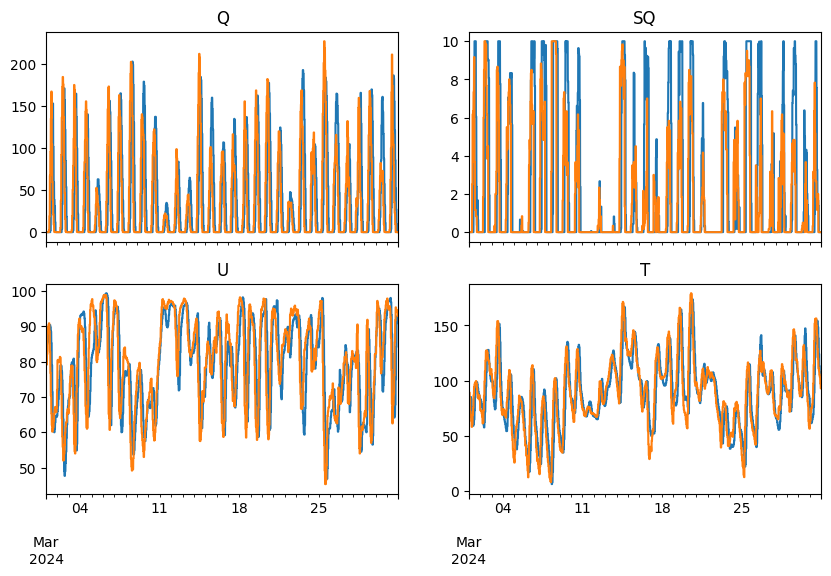

In [41]:
# Check if the data looks reasonable compared to 2024 actuals for a selected month (March)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
weather_fields = ['Q', 'SQ', 'U', 'T']
for wf in range(len(weather_fields)):
    weather_forecast_grouped.loc['2024-03-01':'2024-03-31', weather_fields[wf]].plot(ax=ax[wf//2, wf%2])
    weather_full_grouped.loc['2024-03-01':'2024-03-31', weather_fields[wf]].plot(ax=ax[wf//2, wf%2])
    ax[wf//2, wf%2].set_title(weather_fields[wf])

Data is correctly scaled and appears fairly consistent, with the exception of sunshine duration (SQ), which seems to deviate for high values.
We will explore which of these fields to include in the next section.

## 2. Feature Selection

We will explore potential features to include our model, following on from the above analysis.

We will use `mean absolute error` as our evaluation metric, as predictions are expected to move relatively consistently with true values.

First we will contruct a Naive Model, which we will use a base performance reference. Following the autocorrelation analysis, we will create this by simply shifting load values one week forward. We assess the performance on the 2024 validation data.

In [42]:
data_train = data_full.loc[:'2023-12-31'].copy()
data_valid = data_full.loc['2024-01-01':].copy()

In [43]:
# Naive base model
naive_train_preds = data_train['Load'].shift(7*96)
naive_train_preds.drop(naive_train_preds[:7*96].index, inplace=True)
naive_valid_preds = data_valid['Load'].shift(7*96)
naive_valid_preds.drop(naive_valid_preds[:7*96].index, inplace=True)

print(f'Training MAE: {mean_absolute_error(
    data_train.loc['2016-01-08':, 'Load'], naive_train_preds):.2f}')

print(f'Validation MAE: {mean_absolute_error(
    data_valid.loc['2024-01-08':, 'Load'], naive_valid_preds):.2f}')

Training MAE: 545.30
Validation MAE: 525.07


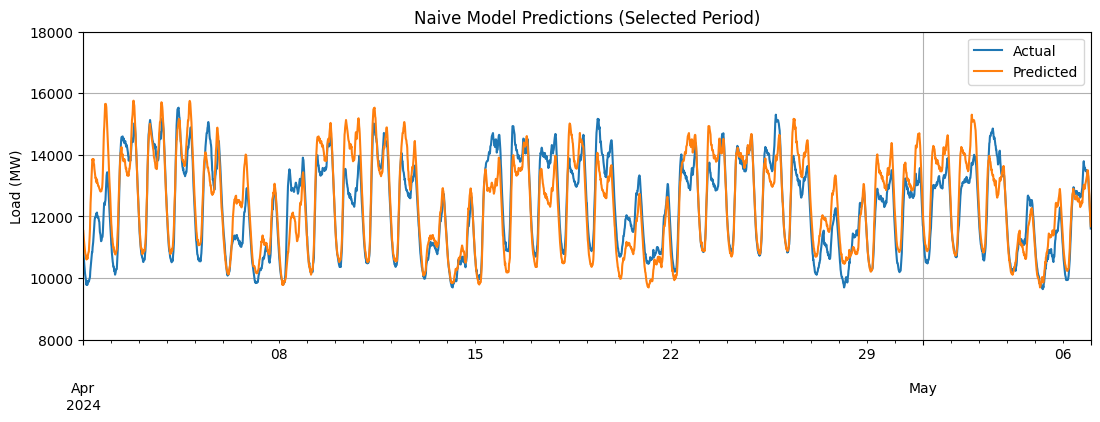

In [44]:
fig, ax = plt.subplots(figsize=(13, 4))
data_valid.loc['2024-04-01':'2024-05-06', 'Load'].plot(ax=ax)
naive_valid_preds['2024-04-01':'2024-05-06'].plot(ax=ax)
ax.set_title('Naive Model Predictions (Selected Period)')
ax.set_ylabel('Load (MW)')
ax.set_xlabel(None)
ax.legend(['Actual', 'Predicted'])
ax.grid()
ax.set_ylim(8000, 18000);

The Naive Model performs fairly well during regular weeks, while performing poorly when demand patterns change, as seen above.

In [45]:
# Transform training and validation data
std_load = StandardScaler()

data_train_transformed = pd.DataFrame(std_load.fit_transform(data_train),
                                      columns=data_train.columns,
                                      index=data_train.index)

data_valid_transformed = pd.DataFrame(std_load.transform(data_valid),
                                           columns=data_valid.columns,
                                           index=data_valid.index)

#### Lagging values
First we will explore the extent of lagging values to include. From our autocorrelation analysis above, we observed that Load values were most correlated to the immediately preceding values, as well as the corresponding daily values of the same time interval, and especially the corresponding weekly value of the same time interval. We will therefore start with:
1. The 24-hour prior value, which is also the most recent known value for any given prediction.
2. The remaining 6 daily values corresponding to the same time interval, therefore including the value exactly 1 week prior.

We will then add both values immediately preceding the 24-hour prior value, as well as further daily values of the same time interval to explore which combination yields the best results.

This can be done by creating 4 week-length lagging scenarios, and then run through additional lagged values from the 24-hour prior value.

In [46]:
# Helper function for adding lagging values
def add_lagging_data(df, lag_weeks=0, lag_days=0, lag_intervals=0, ref_column='Load'):
    """
    Returns a dataframe with lagging feature data equal to specified number of prior periods.
    """
    # 1) add the 24-hour lagged value
    column_values = np.array([df[ref_column].shift(96)])
    column_names = np.array(['Load_1_day_lag'])
    
    #df['Load_24_hour_lag'] = df[ref_column].shift(96)

    # 2) add the lagged 15-min intervals following the lagged 24-hour value
    for interval in range(1, lag_intervals+1):
        column_values = np.concatenate([column_values, [df[ref_column].shift(96+interval)]])
        column_names = np.concatenate([column_names, [f'Load_24_hour_lag+{interval}']])

    # 3) add the lagged daily matching values in weekly periods
    for day in range(2, lag_weeks*7+1):
        column_values = np.concatenate([column_values, [df[ref_column].shift(96*day)]])
        column_names = np.concatenate([column_names, [f'Load_{day}_day_lag']])

    # 4) add additional lagged daily matching values
    for day in range(2, lag_days+1):
        column_values = np.concatenate([column_values, [df[ref_column].shift(96*(lag_weeks*7+day))]])
        column_names = np.concatenate([column_names, [f'Load_{lag_weeks*7+day}_day_lag']])
                
    df = pd.concat([df, pd.DataFrame(column_values.T, columns=column_names,
                                         index=df.index)], axis=1)

    # drop the rows that will include NaN values from shifting
    if lag_weeks==0 and lag_days==0:
        df.drop(df.index[:96+lag_intervals], inplace=True)
    else:
        df.drop(df.index[:(lag_weeks*7+lag_days)*96], inplace=True)    
    
    return df

In [47]:
# Helper function for splitting X_train, X_valid
def prep_X_y(X_train, X_valid=None, ref_column='Load'):
    """
    Splits X_train, X_valid into X_train, y_train, X_valid, y_valid.
    """
    y_train = X_train[ref_column]
    X_train.drop(ref_column, axis=1, inplace=True)

    if X_valid is not None:
        y_valid = X_valid[ref_column]
        X_valid.drop(ref_column, axis=1, inplace=True)
        return X_train, y_train, X_valid, y_valid
    else:
        return X_train, y_train

In [48]:
# Helper function for training and testing a Linear Model
def train_test_linear_model(X_train, y_train, X_valid, y_valid, transformer=std_load,
                            model=LinearRegression(), return_pred=False):
    """
    Trains and tests a linear model, returning training and validation MAE, and predictions if selected.
    """    
    model = model
    model.fit(X_train, y_train)

    y_train_inverse = pd.Series(transformer.inverse_transform([y_train])[0, :],
                                index=y_train.index)
    y_train_pred = pd.Series(transformer.inverse_transform(model.predict(X_train).reshape(-1, 1))[:, 0],
                             index=y_train.index)
    y_valid_inverse = pd.Series(transformer.inverse_transform([y_valid])[0, :],
                                index=y_valid.index)
    y_valid_pred = pd.Series(transformer.inverse_transform(model.predict(X_valid).reshape(-1, 1))[:, 0],
                             index=y_valid.index)

    mae_train = mean_absolute_error(y_train_inverse, y_train_pred)
    mae_valid = mean_absolute_error(y_valid_inverse, y_valid_pred)

    if return_pred:
        return y_train_pred, y_valid_pred, mae_train, mae_valid
    else:
        return mae_train, mae_valid

In [49]:
maes = {}
valid_maes = {}

for week in range(6):
    temp_maes = []
    temp_valid_maes = []
    for interval in range(25):
        X_train = add_lagging_data(data_train_transformed, lag_weeks=week, lag_intervals=interval)
        X_valid = add_lagging_data(data_valid_transformed, lag_weeks=week, lag_intervals=interval)

        X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)
        
        mae_train, mae_valid = train_test_linear_model(X_train, y_train, X_valid, y_valid)
        temp_maes.append(mae_train)
        temp_valid_maes.append(mae_valid)

    maes.update({week: temp_maes})
    valid_maes.update({week: temp_valid_maes})

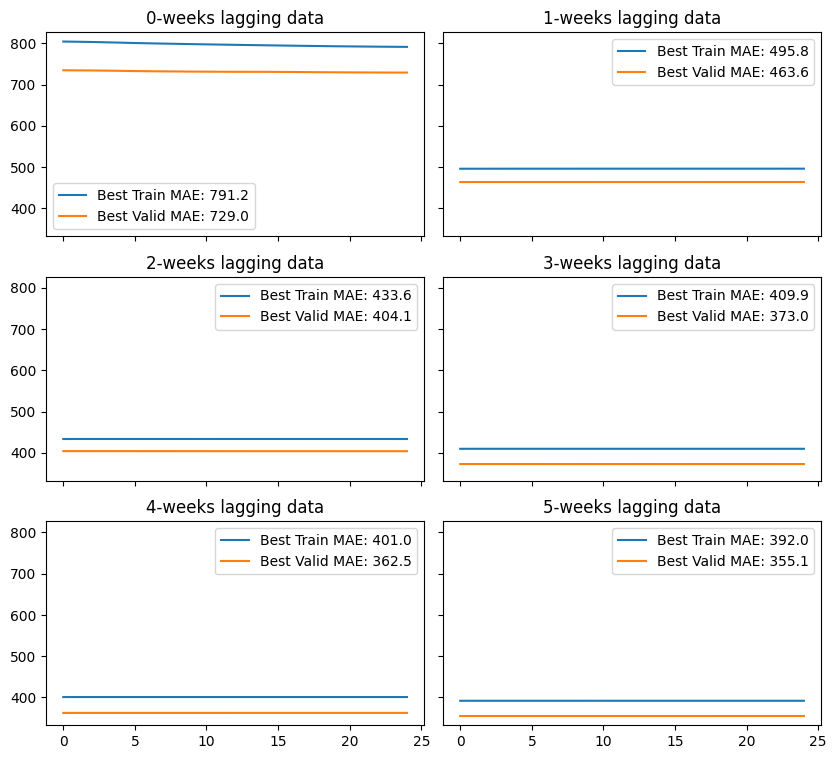

In [50]:
fig, ax = plt.subplots(3, 2, figsize=(10, 9), sharex=True, sharey=True)
for week in range(6):
    ax[week//2, week%2].plot(maes[week])
    ax[week//2, week%2].plot(valid_maes[week])
    ax[week//2, week%2].set_title(f'{week}-weeks lagging data')
    ax[week//2, week%2].legend([f'Best Train MAE: {np.min(maes[week]):.1f}', f'Best Valid MAE: {np.min(valid_maes[week]):.1f}'])

plt.subplots_adjust(wspace=0.05, hspace=0.2)

MAE improves as we add additional weeks of lagging data, with diminishing gains per week added.
The inclusion of additional lagged interval data after the initial 24-hour window has almost no impact. We can therefore focus on lagged daily values corresponding to the same time frame. We will repeat the exercise, adjusting the amount of daily lagged values instead.

In [51]:
maes = []
valid_maes = []

for day in range(43): # 6 weeks * 7 + 1 
    X_train = add_lagging_data(data_train_transformed, lag_weeks=0, lag_days=day, lag_intervals=0)
    X_valid = add_lagging_data(data_valid_transformed, lag_weeks=0, lag_days=day, lag_intervals=0)

    X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)

    mae_train, mae_valid = train_test_linear_model(X_train, y_train, X_valid, y_valid)
    maes.append(mae_train)
    valid_maes.append(mae_valid)

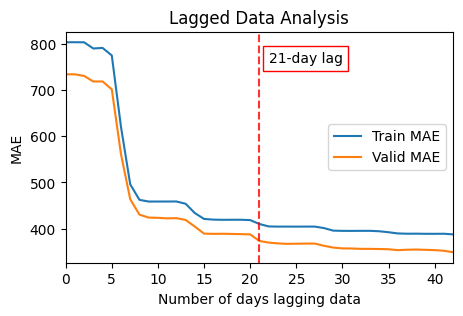

In [52]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(maes)
ax.plot(valid_maes)
ax.set_title('Lagged Data Analysis')
ax.text(22, 760, '21-day lag', color='black', 
        bbox=dict(facecolor='none', edgecolor='red'))
ax.set_xlim(0, 42)
ax.axvline(21, color='red', linestyle='--', alpha=0.8)
ax.legend(['Train MAE', 'Valid MAE'])
ax.set_xlabel('Number of days lagging data')
ax.set_ylabel('MAE');

Lagging data up to 3 weeks appears optimal as most of the MAE gains are captured, which diminish as further lagging data is added.

#### Training Data Window

Our training dataset currently extends from 2016 to 2023. We will evaluate the impact of shifting the starting date of the training data by one year at a time (i.e. reducing the total training data, while focusing increasingly on recent data).

In [53]:
start_dates = [dt.date(year, 1, 1) for year in range(2016, 2024)]

In [54]:
maes = []
valid_maes = []

std_load_start = StandardScaler()

for start_date in start_dates:
    data_start = data_train.loc[start_date:].copy()

    data_start_transformed = pd.DataFrame(std_load_start.fit_transform(data_start),
                                          columns=data_start.columns, index=data_start.index)    
    data_start_valid = pd.DataFrame(std_load_start.transform(data_valid),
                                    columns=data_valid.columns, index=data_valid.index)

    X_train = add_lagging_data(data_start_transformed, lag_weeks=3)
    X_valid = add_lagging_data(data_start_valid, lag_weeks=3)

    X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)

    mae_train, mae_valid = train_test_linear_model(X_train, y_train, X_valid, y_valid, transformer=std_load_start)
    maes.append(mae_train)
    valid_maes.append(mae_valid)

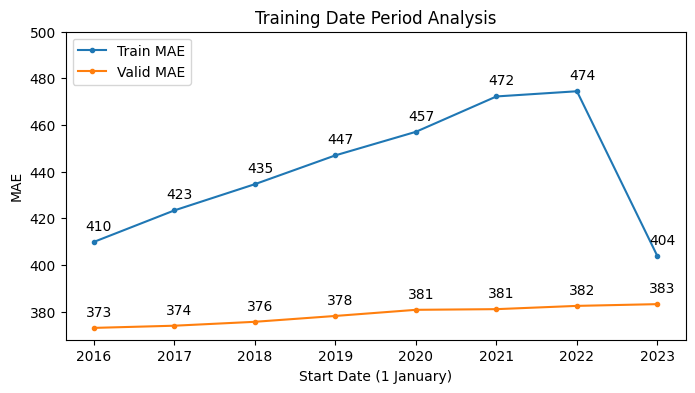

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.Series(maes).plot(ax=ax, marker='.')
pd.Series(valid_maes).plot(ax=ax, marker='.')

for x, y in enumerate(maes):
    ax.annotate(f'{y:.0f}', xy=(x-0.1, y+5))

for x, y in enumerate(valid_maes):
    ax.annotate(f'{y:.0f}', xy=(x-0.1, y+5))

ax.set_ylim(None, 500)
ax.set_xticks(np.arange(8), [year for year in pd.to_datetime(start_dates).year])
ax.set_xlabel('Start Date (1 January)')
ax.set_ylabel('MAE')
ax.legend(['Train MAE', 'Valid MAE'])
ax.set_title('Training Date Period Analysis');

Validation MAE increases gradually as we shift the starting date to the right, while training MAE increases more rapidly, before dropping off when only a single year (2023) is used. This would be due to overfitting the training data. We will therefore include the full training data in our model.

In [56]:
# Re-run data transformation on full data
data_train_transformed = pd.DataFrame(std_load.fit_transform(data_train),
                                      columns=data_train.columns,
                                      index=data_train.index)

data_valid_transformed = pd.DataFrame(std_load.transform(data_valid),
                                           columns=data_valid.columns,
                                           index=data_valid.index)

#### Weekday/Holiday

Next we will include dummy variables representing the day of the week or holiday. As we will include lagging weekly data, it is possible that most of the daily profile information is already captured in this data, with the exception of holidays (that fall on weekdays) as these will have a different profile to the corresponding lagged data.

First we will only add holiday information, and thereafter we will add weekday information to see if there is any further improvement in model performance.

In [57]:
# Helper function
def add_weekday_holiday(df, add_weekdays=False):
    """
    Adds holiday days to a DataFrame. If specified, adds weekdays as well.
    """
    if add_weekdays:
        df['Weekday'] = df.index.weekday
        df = pd.get_dummies(df, columns=['Weekday'], drop_first=True)
        df.rename(columns={old_name: new_name for old_name, new_name in zip(
            [column for column in df.columns if 'Weekday' in column],
            ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])}, inplace=True)
    
    df['Holiday'] = pd.to_datetime(df.index.date).isin(pd.to_datetime(public_holidays_full))
    
    return df

In [58]:
for add_weekday in [False, True]:
    X_train = add_lagging_data(data_train_transformed, lag_weeks=3)
    X_train = add_weekday_holiday(X_train, add_weekdays=add_weekday)
    X_valid = add_lagging_data(data_valid_transformed, lag_weeks=3)
    X_valid = add_weekday_holiday(X_valid, add_weekdays=add_weekday)

    X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)
    
    mae_train, mae_valid = train_test_linear_model(X_train, y_train, X_valid, y_valid)

    if not add_weekday:
        print('Results - holiday only')
    else:
        print('\nResults - weekday and holiday')
    print(f'  Training MAE: {mae_train:.2f}')
    print(f'  Validation MAE: {mae_valid:.2f}')

Results - holiday only
  Training MAE: 404.24
  Validation MAE: 364.36

Results - weekday and holiday
  Training MAE: 403.37
  Validation MAE: 366.21


Adding the holiday feature improves training and validation MAE, while adding the weekday features slightly worsens validation MAE (with a tiny improvement in training MAE). While a public holiday would result in a different demand profile (especially during a weekday), the regular weekday information is likely already captured in the lagging load data. We will therefore inlude only the holiday feature.

#### Weather Data
From our analysis above, we observed that load values were moderately correlated (0.3 < p < 0.5) with the rolling weekly averages of the following weather fields:
- Q - global radiation
- SQ - sunshine duration
- U - relative humidity
- T - temperature

Furthermore, these fields exhibit a relatively consistent relationship with each other. We will therefore start by including Q as a feature variable, incrementally followed by the others to see if they add predictive value to our model.

In [59]:
# Reprocess weather data to align transformer and features
weather_full_grouped = weather_full_grouped[['Q', 'SQ', 'U', 'T']]
weathe_full_transformed = pd.DataFrame(std_weather.fit_transform(weather_full_grouped),
                                            columns=weather_full_grouped.columns,
                                            index=weather_full_grouped.index)

weather_full_rolling_daily = weather_full_transformed.rolling(window=7).mean()
weather_full_rolling_weekly = weather_full_transformed.rolling(window=7*96).mean()

weather_forecast_transformed = pd.DataFrame(std_weather.transform(weather_forecast_grouped),
                                            columns=weather_forecast_grouped.columns,
                                            index=weather_forecast_grouped.index)

weather_forecast_rolling_daily = weather_forecast_transformed.rolling(window=7).mean()
weather_forecast_rolling_weekly = weather_forecast_transformed.rolling(window=7*96).mean()

In [60]:
def add_weather_data(df_load, df_weather, weather_fields):
    """
    Adds weather data based on a specified DataFrame.
    """
    df_load = df_load.merge(df_weather[weather_fields],
                            left_index=True, right_index=True)
    
    return df_load

In [61]:
maes = [[], [], []]
valid_maes = [[], [], []]
weather_data = [[weather_full_transformed, weather_full_rolling_daily, weather_full_rolling_weekly],
                [weather_forecast_transformed, weather_forecast_rolling_daily, weather_forecast_rolling_weekly]]

for i in range(3):
    for j in range(1, 5):
        X_train = add_lagging_data(data_train_transformed, lag_weeks=3)
        X_train = add_weekday_holiday(X_train)
        X_valid = add_lagging_data(data_valid_transformed, lag_weeks=3)
        X_valid = add_weekday_holiday(X_valid)
    
        weather_fields = ['Q', 'SQ', 'U', 'T'][:j]

        X_train = add_weather_data(X_train, weather_data[0][i], weather_fields)
        X_valid = add_weather_data(X_valid, weather_data[1][i], weather_fields)

        X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)

        mae_train, mae_valid = train_test_linear_model(X_train, y_train, X_valid, y_valid)
        maes[i].append(mae_train)
        valid_maes[i].append(mae_valid)

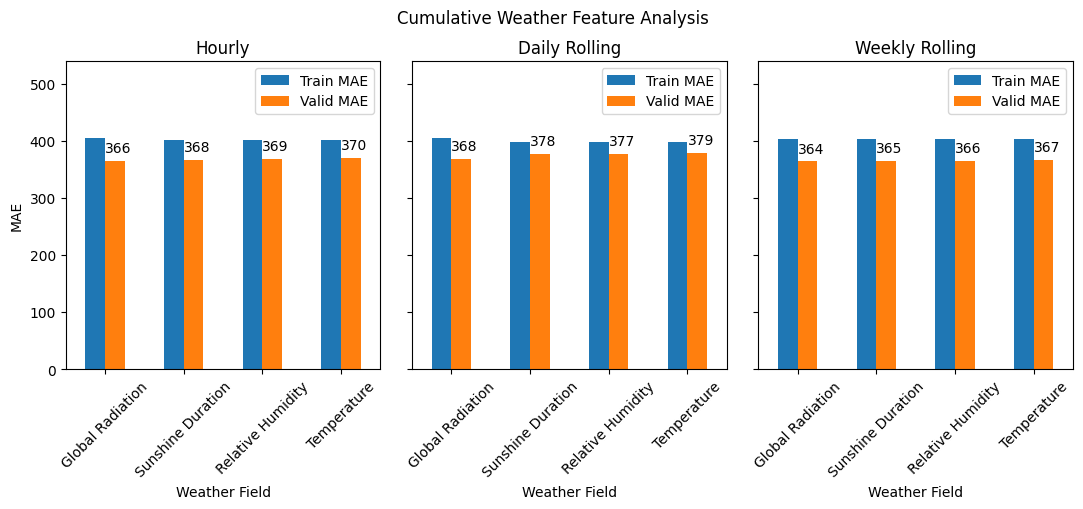

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
ax_titles = ['Hourly', 'Daily Rolling', 'Weekly Rolling']

for i in range(3):
    pd.DataFrame({'Weather Field': weather_fields,
                  'Train MAE': maes[i],
                  'Valid MAE': valid_maes[i]}).plot(kind='bar', x='Weather Field', ax=ax[i])

    ax[i].set_xticks(np.arange(4), ['Global Radiation', 'Sunshine Duration', 'Relative Humidity', 'Temperature'], rotation=45)
    ax[i].set_ylabel('MAE')
    ax[i].set_title(ax_titles[i])
    ax[i].set_ylim(0, 540)

    for x, y in enumerate(valid_maes[i]):
        ax[i].annotate(f'{y:.0f}', xy=(x, y+15))

plt.subplots_adjust(wspace=0.1)
fig.suptitle('Cumulative Weather Feature Analysis', y=1.01);

Weather fields do not yield an improved performance in validation MAE. We will therefore not include them in the model.

#### In Summary
We will include the following feature variables in our model:
- Lagging load values corresponding to the same time interval of the prior 3 weeks (21 values).
- Holiday indicator (1 value).

## 3. Model Selection and Evaluation

Now that we have determined the features to include, we will first train our Linear Regression model and further investigate the results. Thereafer we will train other models and explore further ways to improve model performance.

In [63]:
# Set y_true values
y_train_true = data_train.loc['2016-01-22':, 'Load']
y_valid_true = data_valid.loc['2024-01-22':, 'Load']

# Prepare model data
X_train = add_lagging_data(data_train_transformed, lag_weeks=3)
X_train = add_weekday_holiday(X_train)
X_valid = add_lagging_data(data_valid_transformed, lag_weeks=3)
X_valid = add_weekday_holiday(X_valid)

X_train, y_train, X_valid, y_valid = prep_X_y(X_train, X_valid)

lin_reg_model = LinearRegression() # keep model outide of function to be able to access it later

y_train_pred, y_valid_pred, mae_train, mae_valid = train_test_linear_model(
    X_train, y_train, X_valid, y_valid, model=lin_reg_model, return_pred=True)

In [64]:
# Helper function to visualise model results
def plot_results(y_true, y_pred, figsize=(12, 6), title=None):
    """
    Plots y_true vs y_pred, and delta graph.
    """
    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True)
    y_true.plot(ax=ax[0], label='Actual')
    y_pred.plot(ax=ax[0], label='Predicted')
    ax[0].legend()
    ax[0].set_ylabel('Load (MW)')
    ax[0].grid()

    ax[0].set_ylim(y_true.min()//1000*1000, (y_true.max()//1000+1)*1000)
    ax[0].set_title(title)

    delta = y_pred - y_true
    delta.plot(ax=ax[1])
    ax[1].axhline(0)
    ax[1].set_ylabel('Delta (MW)')
    ax[1].grid()
    ax[1].set_ylim(delta.min()//1000*1000, (delta.max()//1000+1)*1000)
    plt.xlabel(None)
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')

MAE: 364.36


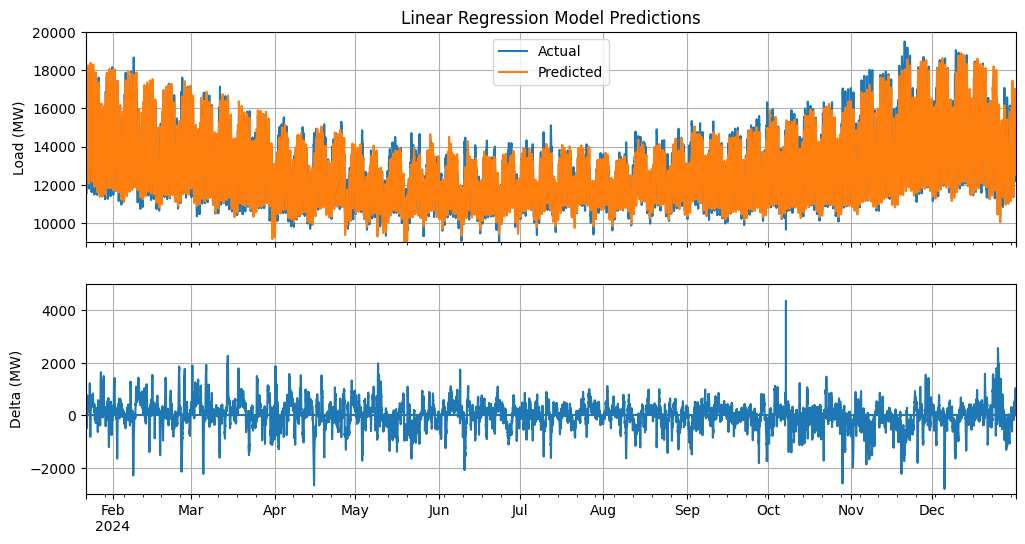

In [65]:
plot_results(y_valid_true, y_valid_pred, title='Linear Regression Model Predictions')

MAE: 415.13


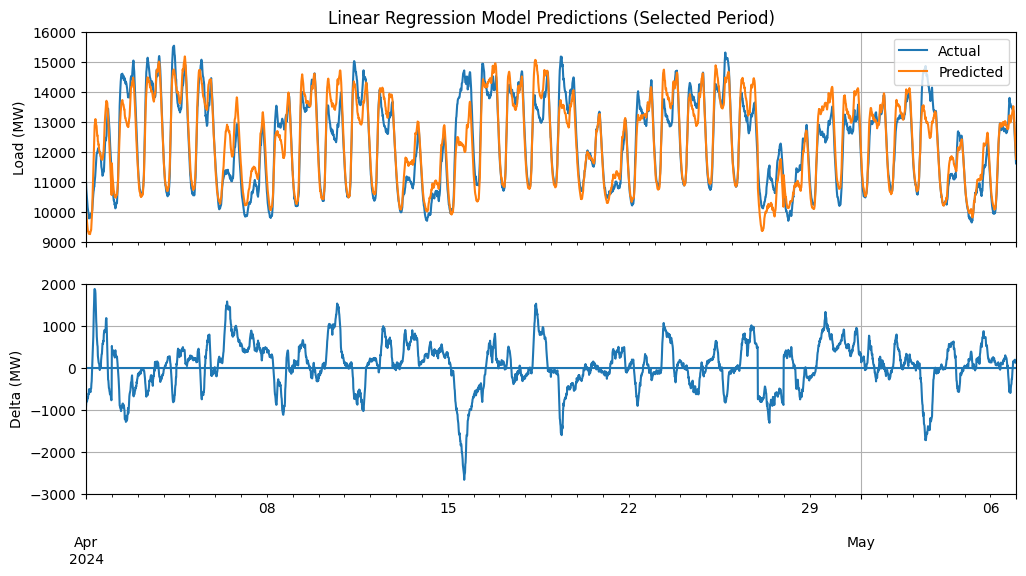

In [66]:
# Zoomed in on April 2024 (selected month, starting on a Monday)
plot_results(y_valid_true.loc['2024-04-01':'2024-05-06'],
             y_valid_pred.loc['2024-04-01':'2024-05-06'],
             title='Linear Regression Model Predictions (Selected Period)')

As we can see in the full year plot, there's a single significant deviation in October. Let's take a closer look.

In [67]:
X_valid.iloc[(y_valid_true - y_valid_pred).abs().argmax()].name

Timestamp('2024-10-07 16:30:00')

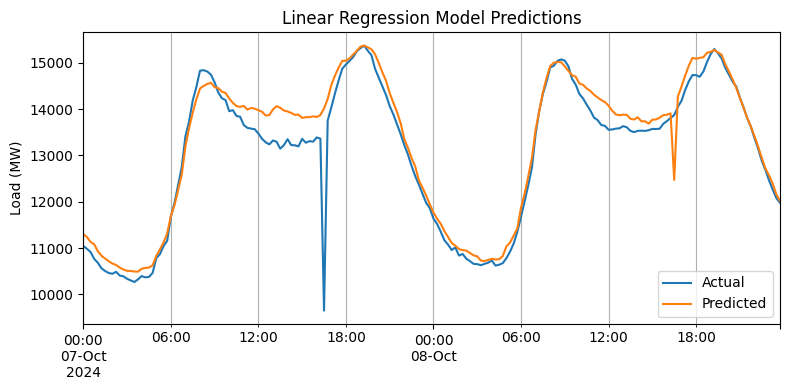

In [68]:
# Plot the day
fig, ax = plt.subplots(figsize=(8, 4))
y_valid_true.loc['2024-10-07':'2024-10-08'].plot(ax=ax, label='Actual')
y_valid_pred.loc['2024-10-07':'2024-10-08'].plot(ax=ax, label='Predicted')
ax.grid(axis='x', which='both')
ax.set_title('Linear Regression Model Predictions')
ax.set_ylabel('Load (MW)')
ax.legend()
ax.set_xlabel('')
plt.tight_layout();

In [69]:
data_valid.loc['2024-10-07 15:0:00':'2024-10-07 18:00:00']['Load']

Date
2024-10-07 15:00:00    13359.0
2024-10-07 15:15:00    13275.0
2024-10-07 15:30:00    13309.0
2024-10-07 15:45:00    13298.0
2024-10-07 16:00:00    13389.0
2024-10-07 16:15:00    13363.0
2024-10-07 16:30:00     9652.0
2024-10-07 16:45:00    13754.0
2024-10-07 17:00:00    14039.0
2024-10-07 17:15:00    14340.0
2024-10-07 17:30:00    14619.0
2024-10-07 17:45:00    14872.0
2024-10-07 18:00:00    14963.0
Name: Load, dtype: float64

This appears to be an error in data capture as the MW value suddenly drops off significantly for a single time interval. As our model predicts based on rolling data values, it will incorrectly predict the corresponding next day value based on this anomaly value, however, at a lower rate due to the look-back period. This is seen above and in the mirrored delta values in both directions.

#### Other Linear Models
We will explore some other linear models to see if any yield promising performance results compared to our Linear Regression model.

In [70]:
model_dict = {'SGD': SGDRegressor(random_state=1),
             'Lasso': Lasso(),
              'Ridge': Ridge(),
              'ElasticNet': ElasticNet()}

In [71]:
# Model performances
summary_df = pd.DataFrame({
    'Training MAE': [mae_train],
    'Validation MAE': [mae_valid]
}, index=['Linear Regression'])

In [72]:
for model_name, model in model_dict.items():
    mae_t, mae_v = train_test_linear_model(X_train, y_train, X_valid, y_valid, model=model)
    new_row = pd.DataFrame({'Training MAE': mae_t, 'Validation MAE': mae_v}, index=[model_name])
    summary_df = pd.concat([summary_df, new_row])

In [73]:
summary_df = summary_df.round(2)
summary_df

,Training MAE,Validation MAE
Linear Regression,404.24,364.36
SGD,413.85,368.88
Lasso,1760.76,1560.78
Ridge,404.24,364.36
ElasticNet,1185.53,1030.43


Looking at the results, it does not appear that other linear models will yield better performance:
- SGD: SGD may deliver a slightly better validation MAE performance, depending on the particular weights it finds in a training round, although as we can see below, these fluctuate closely around our base performance. Ultimately the improved performance of a particular training round is not expected to scale to further test sets.
- Lasso: L1 regularisation significantly decreases the performance of our model.
- Ridge: L2 regularation yields a very slight improvement over our base performance for a range of alpha values. Looking at the results below, it would appear that the regularisation at these levels results in a similar solution with a different combination of feature weights. Ultimately the improvement is validation MAE is negligible, and would not necessarily generalise to future data.
- ElasticNet: the combination of L1 and L2 regularisation yields the decrease in performance associated with L1 regularisation (see Lasso).

In [74]:
mae_sgd_t = []
mae_sgd_v = []
for i in range(50):
    sgd_model = SGDRegressor()
    mae_t, mae_v = train_test_linear_model(X_train, y_train, X_valid, y_valid, model=sgd_model)
    mae_sgd_t.append(mae_t)
    mae_sgd_v.append(mae_v)

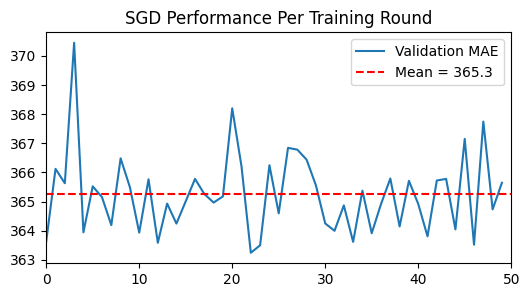

In [75]:
pd.Series(mae_sgd_v).plot(figsize=(6, 3), label='Validation MAE')
plt.title('SGD Performance Per Training Round')
plt.axhline(np.mean(mae_sgd_v), color='red', label=f'Mean = {np.mean(mae_sgd_v):.1f}', linestyle='--')
plt.legend()
plt.xlim(0, 50);

In [76]:
mae_ridge_t = []
mae_ridge_v = []
ridge_alphas = np.concatenate([[0], np.logspace(-2, 2, 5), np.arange(200, 2001, 100), [3000, 4000]])
for a in ridge_alphas:
    ridge_model = Ridge(alpha=a)
    mae_t, mae_v = train_test_linear_model(X_train, y_train, X_valid, y_valid, model=ridge_model)
    mae_ridge_t.append(mae_t)
    mae_ridge_v.append(mae_v)

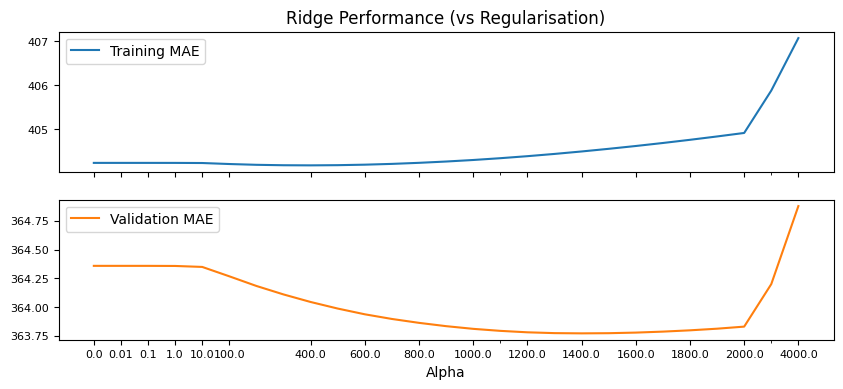

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

pd.Series(mae_ridge_t).plot(ax=ax[0], label='Training MAE')
ax[0].set_title('Ridge Performance (vs Regularisation)')
ax[0].set_xticks(np.concatenate([[0], np.arange(1, 6), np.arange(8, 25, 2), [26]]), 
           np.concatenate([[0], np.logspace(-2, 2, 5), np.arange(400, 2001, 200), [4000]]))
ax[0].tick_params(labelsize=8)
ax[0].legend()
ax[0].annotate(round(mae_ridge_v[0],2), xy=(-0.15, 418))

pd.Series(mae_ridge_v).plot(ax=ax[1], label='Validation MAE', color='#ff7f0e')
ax[1].set_xticks(np.concatenate([[0], np.arange(1, 6), np.arange(8, 25, 2), [26]]), 
           np.concatenate([[0], np.logspace(-2, 2, 5), np.arange(400, 2001, 200), [4000]]))
ax[1].tick_params(labelsize=8)
ax[1].legend()
ax[1].set_xlabel('Alpha')
ax[1].annotate(round(mae_ridge_v[0],2), xy=(-0.15, 418));

In [78]:
ridge_alphas[np.array(mae_ridge_v).argmin()]

1400.0

In [79]:
ridge_model = Ridge(alpha=1400)
ridge_model.fit(X_train, y_train);

We see a very slight improvement in Validation MAE for a range of alpha values. Training the Ridge model with the optimal alpha value (1400) and comparing the predictions to that of the Linear Regression model (for a selected month), reveal a very close result. It would appear that the regularisation at these levels results in a similar solution with a different combination of feature weights.

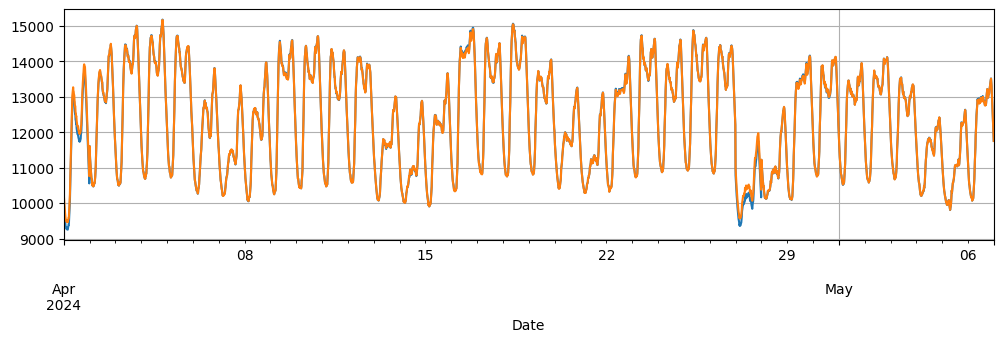

In [80]:
fig, ax = plt.subplots(figsize=(12, 3))

pd.Series(std_load.inverse_transform(lin_reg_model.predict(X_valid).reshape(-1, 1))[:, 0],
          index=y_valid.index).loc['2024-04-01':'2024-05-06'].plot(ax=ax)

pd.Series(std_load.inverse_transform(ridge_model.predict(X_valid).reshape(-1, 1))[:, 0],
          index=y_valid.index).loc['2024-04-01':'2024-05-06'].plot(ax=ax);

ax.grid();

#### Hybrid Model

Next we will explore if we can combine the Linear Regression model with XGBoost, trained on the residuals to create a hybrid model.

In [81]:
resid = pd.DataFrame(y_train_true - y_train_pred, columns=['Residual'])

In [82]:
resid_time = resid.copy()
resid_time['Time'] = resid_time.index.time
resid_time_by_day = resid_time.groupby('Time')['Residual'].mean()

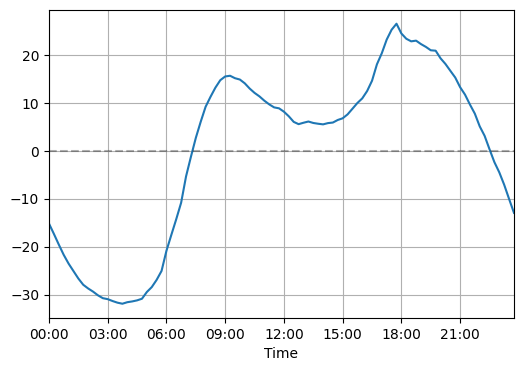

In [83]:
fig, ax = plt.subplots(figsize=(6, 4))
resid_time_by_day.plot(ax=ax)
ax.set_xlim('00:00:00','23:45:00')
ax.set_xticks(resid_time_by_day.index[::12])
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.grid();

The mean residual pattern looks similar to the mean daily demand profile. This is due to both greater variability during peak periods as well as greater absolute residuals on the same percentage error at a higher value. We will fit a polynomial to the mean daily demand profile to see if we can use it to improve our model performance.

In [84]:
data_time_df=data_time_pivot.drop('Year', axis=1).mean()

In [85]:
# Fit a polynomial function to represent the relationship of time of day and load
data_time_df = data_time_pivot.drop('Year', axis=1).mean().to_frame()
data_time_df.columns = ['Load']
data_time_df['Load'] = std_load.transform(data_time_df[['Load']])
data_time_df.insert(loc=0, column='Time_X', value = (np.arange(96) / 96))

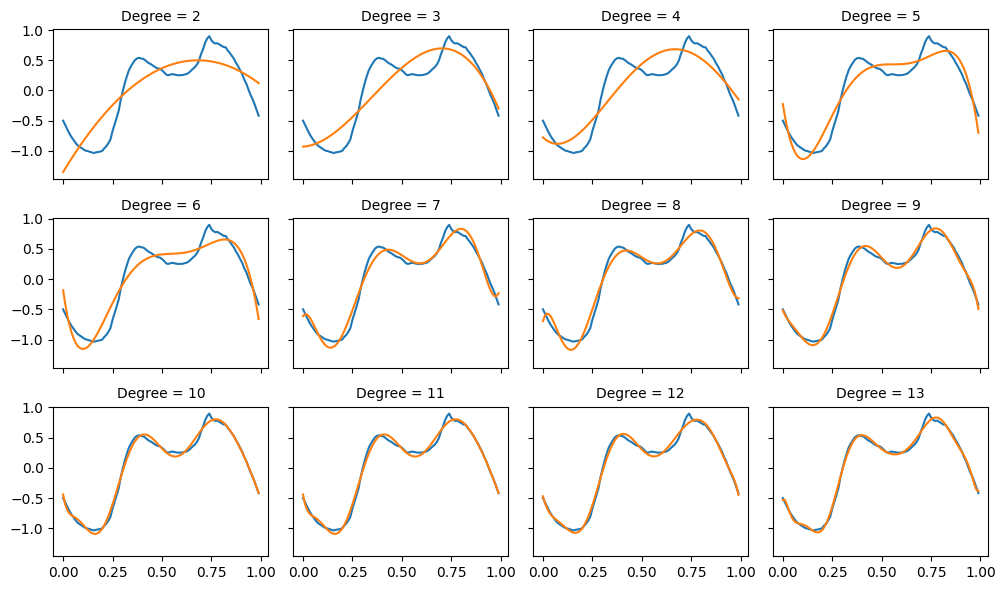

In [86]:
fig, ax = plt.subplots(3, 4, figsize=(10, 6), sharex=True, sharey=True)
axes = ax.ravel()

for i in range(12):
    poly = PolynomialFeatures(degree=(i+2), include_bias=False)
    X_ = poly.fit_transform(data_time_df[['Time_X']])

    clf = LinearRegression()
    clf.fit(X_, data_time_df['Load'])

    predict = clf.predict(X_)

    data_time_df.plot(x='Time_X', y='Load', ax=axes[i])
    pd.Series(predict, index=data_time_df['Time_X']).plot(ax=axes[i])
    axes[i].legend().remove()
    axes[i].set_title(f'Degree = {(i+2)}', fontsize=10)
    axes[i].set_xlabel(None)

plt.tight_layout()

The 9th-degree polynomial fits the mean load fairly well.

In [87]:
poly = PolynomialFeatures(degree=(7+2), include_bias=False)

X_ = poly.fit_transform(data_time_df[['Time_X']])

In [88]:
def add_time_poly(df):
    """
    Adds Polynomial Features for time of day to a DataFrame.
    """
    df = df.merge(
    pd.DataFrame(np.vstack([X_] * int(len(df) / 96)),
                       columns=[f'Degree_{i+1}' for i in range(9)],
                       index=df.index),
    left_index=True, right_index=True
    )

    return df

In [89]:
X_train_boost = X_train.copy()
X_train_boost = add_time_poly(X_train_boost)

In [90]:
xgb = XGBRegressor()
xgb.fit(X_train_boost, resid['Residual']);

In [91]:
train_preds_boost = xgb.predict(X_train_boost)
train_preds_boost_final = train_preds_boost + y_train_pred

print(f'Training MAE: {mean_absolute_error(y_train_true, train_preds_boost_final):.2f}')

Training MAE: 260.38


In [92]:
X_valid_boost = X_valid.copy()
X_valid_boost = add_time_poly(X_valid_boost)

In [93]:
valid_preds_boost = xgb.predict(X_valid_boost)
valid_preds_boost_final = valid_preds_boost + y_valid_pred

print(f'Validation MAE: {mean_absolute_error(y_valid_true, valid_preds_boost_final):.2f}')

Validation MAE: 339.18


The XGBoost hybrid model improves training MAE performance substantially, with some improvement in validation MAE as well. This is likely because the model is learning from the training residuals so will improve well on the training data. Some of this does generalise to the validation data as well. We will explore the model hyperparameters to see if we can further optimise its performance.

#### Hyperparameter Tuning

In [94]:
resid_valid = pd.DataFrame(y_valid_true - y_valid_pred, columns=['Residual'])

In [95]:
# To keep the validation data out of the process, we will use CV on the training set
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 6, 7],
              'min_child_weight': [1, 2, 3],
              'eta': [0.4, 0.5]
             }

grid = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    cv=5
)

grid.fit(X_train_boost, resid['Residual']);

In [96]:
grid.best_params_

{'eta': 0.4, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}

In [97]:
print(f'MAE (tuned hybrid model): {
mean_absolute_error(y_valid_true, (y_valid_pred + grid.predict(X_valid_boost))):.2f
}')

MAE (tuned hybrid model): 343.94


The tuned model does not yield an improved performance over the hybird model with the default XBGRegressor hyperparameters. We will therefore us the default hybrid as our final model.

In [98]:
xgb = XGBRegressor()
xgb.fit(X_train_boost, resid['Residual']);

#### Evaluating Final Model on the Test Data

We will create a simple `HybridModel` class to consolidate the fitting and prediction process of the hybrid model.

In [99]:
class HybridModel:
    def __init__(self, model_1=LinearRegression(), model_2=XGBRegressor(), std=std_load):
        self.model_1 = model_1
        self.model_2 = model_2
        self.std = std

    def fit(self, X_train, y_train):
        self.model_1.fit(X_train, y_train)
        y_pred = pd.Series(self.std.inverse_transform(self.model_1.predict(X_train).reshape(-1, 1))[:, 0],
                                index=y_train.index)
        y_train = pd.Series(self.std.inverse_transform([y_train])[0, :],
                                index=y_train.index)
        self.resid = y_train - y_pred
        X_train_boosted = add_time_poly(X_train)
        self.model_2.fit(X_train_boosted, resid)

    def predict(self, X_test):
        y_pred_linear = pd.Series(self.std.inverse_transform(self.model_1.predict(X_test).reshape(-1, 1))[:, 0],
                                index=X_test.index)
        X_test_boosted = add_time_poly(X_test)
        y_pred_boosted = self.model_2.predict(X_test_boosted)
        y_pred_final = y_pred_linear + y_pred_boosted
        return y_pred_final

In [100]:
# We will use the full 2025 data (by combining the last 21 days of 2024 for creating the lagging feature data) 
data_test = pd.concat([
    data_valid.loc['2024-12-11':],
    data_2025.loc['2025-01-01':],
])

y_test_true = data_test.loc['2025-01-01':, 'Load']

data_test_transformed = pd.DataFrame(std_load.transform(data_test),
                                          columns=data_test.columns,
                                          index=data_test.index)

X_test = add_lagging_data(data_test_transformed, lag_weeks=3)
X_test = add_weekday_holiday(X_test)

X_test, y_test = prep_X_y(X_test)

MAE: 422.13


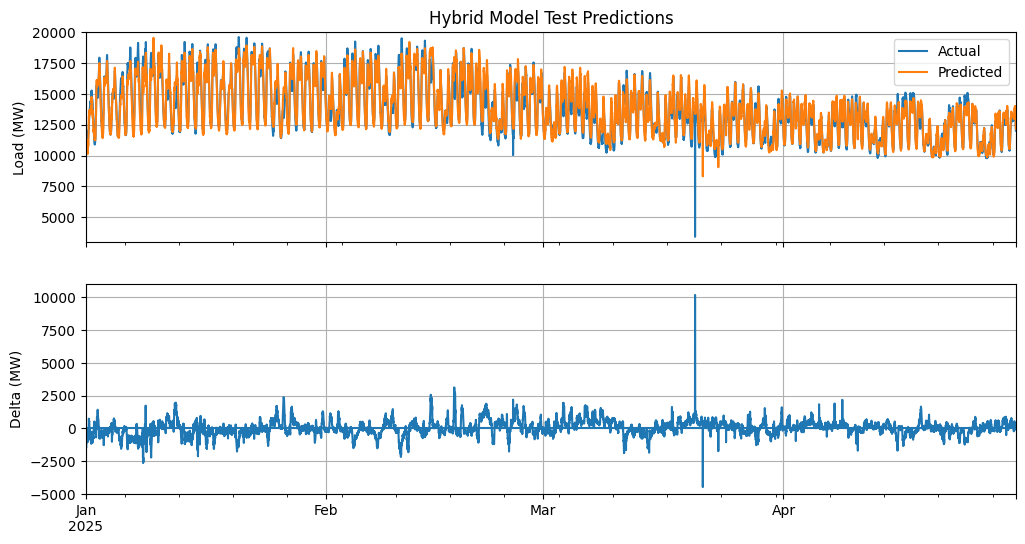

In [101]:
hybrid_model = HybridModel()
hybrid_model.fit(X_train, y_train)
y_test_pred = hybrid_model.predict(X_test)

plot_results(y_test_true, y_test_pred, title='Hybrid Model Test Predictions')

MAE: 297.34


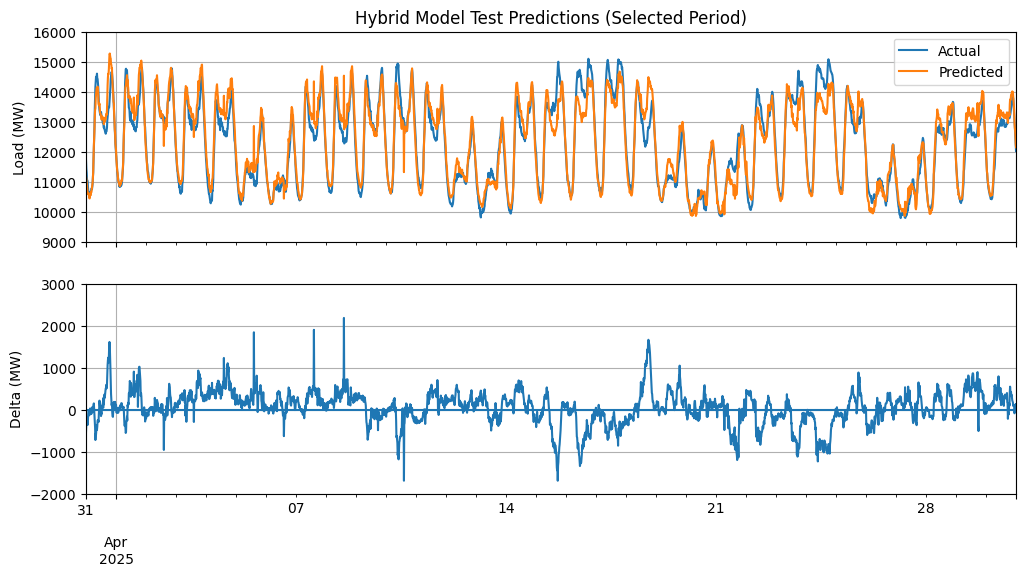

In [102]:
plot_results(y_test_true.loc['2025-03-31':],
             y_test_pred.loc['2025-03-31':],
             title='Hybrid Model Test Predictions (Selected Period)');

The above period includes a public holiday on Monday, 21 April. We can see the electricity demand profile following the weekend/holiday shape. The model has predicted an even lower demand than the actual for the day.

As we can see in the year plot, there is a single significant deviation in March. Let's take a closer look.

In [103]:
X_test.iloc[(y_test_true - y_test_pred).abs().argmax()].name

Timestamp('2025-03-20 14:15:00')

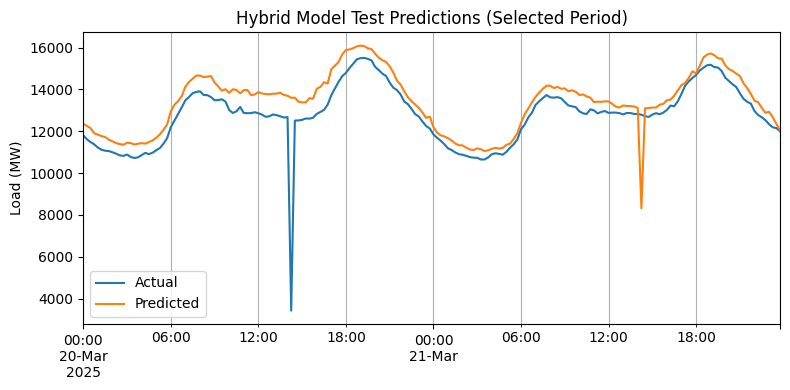

In [104]:
# Plot the day
fig, ax = plt.subplots(figsize=(8, 4))
y_test_true.loc['2025-03-20':'2025-03-21'].plot(ax=ax, label='Actual')
y_test_pred.loc['2025-03-20':'2025-03-21'].plot(ax=ax, label='Predicted')
ax.grid(axis='x', which='both')
ax.set_title('Hybrid Model Test Predictions (Selected Period)')
ax.set_ylabel('Load (MW)')
ax.legend()
ax.set_xlabel('')
plt.tight_layout();

In [105]:
data_test.loc['2025-03-20 13:00:00':'2025-03-20 15:00:00']['Load']

Date
2025-03-20 13:00:00    12799.0
2025-03-20 13:15:00    12768.0
2025-03-20 13:30:00    12714.0
2025-03-20 13:45:00    12655.0
2025-03-20 14:00:00    12675.0
2025-03-20 14:15:00     3426.0
2025-03-20 14:30:00    12508.0
2025-03-20 14:45:00    12516.0
2025-03-20 15:00:00    12544.0
Name: Load, dtype: float64

Similar to what we observed in the validation data above, this appears to be an error in data capture as the MW value suddenly drops off significantly for a single time interval. As our model predicts based on rolling data values, it will incorrectly predict the corresponding next day value based on this anomaly value, however, at a lower rate due to the look-back period. This is seen above and in the mirrored delta values in both directions. The impact of this deviation is carried forward further in the prediction values up to 10 April 2025, as seen above. For a production model, we should consider smoothing these anomaly values to eliminate their impact on the forecast values.

## 4. Final Results

In [106]:
# Helper function for returning maes
def invert_pred(y_true, y_pred, transformer=std_load):
    return pd.Series(transformer.inverse_transform(y_pred.reshape(-1, 1))[:, 0],
                     index=y_true.index)

def mae(y_true, y_pred, invert=True):
    if invert:
        return mean_absolute_error(y_true, invert_pred(y_true, y_pred))
    else:
        return mean_absolute_error(y_true, y_pred)

In [107]:
lin_mae_train = mae(y_train_true, lin_reg_model.predict(X_train))
lin_mae_valid = mae(y_valid_true, lin_reg_model.predict(X_valid))
lin_mae_test = mae(y_test_true, lin_reg_model.predict(X_test))

hybrid_mae_train = mae(y_train_true, hybrid_model.predict(X_train), invert=False)
hybrid_mae_valid = mae(y_valid_true, hybrid_model.predict(X_valid), invert=False)
hybrid_mae_test = mae(y_test_true, hybrid_model.predict(X_test), invert=False)

In [108]:
final_summary_df = pd.DataFrame({
    'Training MAE': [lin_mae_train, hybrid_mae_train],
    'Validation MAE': [lin_mae_valid, hybrid_mae_valid],
    'Test MAE': [lin_mae_test, hybrid_mae_test]
}, index=['Linear Regression', 'Hybrid Model'])

for model in final_summary_df.index:
    final_summary_df.loc[f'{model} (%)'] = (final_summary_df.loc[model] / 
                                            (y_train_true.mean(), y_valid_true.mean(), y_test_true.mean()) * 100)

final_summary_df = final_summary_df.round(2)
final_summary_df

,Training MAE,Validation MAE,Test MAE
Linear Regression,404.24,364.36,462.03
Hybrid Model,260.38,339.18,422.13
Linear Regression (%),3.22,2.81,3.36
Hybrid Model (%),2.07,2.61,3.07


The model with the best performance is the hybird `LinearRegression`, `XGBRegressor` model, achieving a final MAE of 422.13 on the test set, or mean deviation of 3.07%.

The models perform more poorly on the test data, as compared to the validation data. This is expected for two reasons:
1. Feature engineering was optimised with consideration of validation MAE and so performance is expected to decrease on new data.
2. The validation set performed unusually well, even compared to the training data. This is likely due to the particulars of the 2024 year that, for example, may have followed a more consistent pattern over the single year compared to those seen over the training data. In the case of the hybrid model, training MAE is highly optimised through the XGBoost step, resulting in a larger gap between training and validation/test MAE, as not all of this will generalise to new data. In the case of the Linear Regression model, the gap between training MAE and test MAE shows a more typical train/test gap.